# Pneumonia identification from X-Ray Images
---

*Authors* : Natalia García Sánchez, Ana Solbas Casajús

*Subject*: Big Data Engineering - Masters Degree in Computational Biology

*Date*: 24/01/2023


*Description* : Code implementing Spark-based machine learning models for classification of X-Ray images from a Pediatric Chest X-Ray Image dataset, with the purpose of predicting Pneumonia in patients. More specifically, it will implement this models using the high level pyspark interfaces and BigDL as a platform to develop scalable deep learning applications.

---

## INDEX OF CONTENTS

**INTRODUCTION**


**MATERIALS AND METHODS**

  **1.** Dependencies and tools used

  **2.** Data Import

  **3.** Data Preprocessing

  **4.** Keras NN model implementation  

  **5.** Model training using MLlib from PySpark

  **6.** Model training using BigDL

**CONCLUSION**

**REFERENCES**

# INTRODUCTION

Pneumonia is a type of respiratory infection that affects the lungs and is caused by a variety of organisms, including bacteria, viruses, and fungi. It is the eighth leading cause of death, it has a mortality rate of 23% for patients admitted to the Intensive Care Unit (ICU) (Regunath & Oba, 2022),  and it is estimated as the leading cause of death among children under 5 years old, with nearly all cases occurring in developing countries (Rudan et al., 2008). Pneumonia is the leading cause of death among children under 5 years old, with nearly all cases occurring in developing countries. 

Symptoms include cough, fever, difficulty breathing, shortness of breath, chest pain, and rapid breathing, caused by the filling of lung air sacs or alveoli (_**Figure 1**_) with purulent material. Diagnosis is based on symptoms, physical examination, chest X-rays, blood tests, and sputum culture (Pneumonia - Diagnosis | NHLBI).  Bacterial and viral pathogens are the two main causes of pneumonia and require different forms of treatment - Bacterial pneumonia calls for antibiotic treatment, while patients with viral pneumonia are generally referred to the ICU- (Mcluckie, 2009).



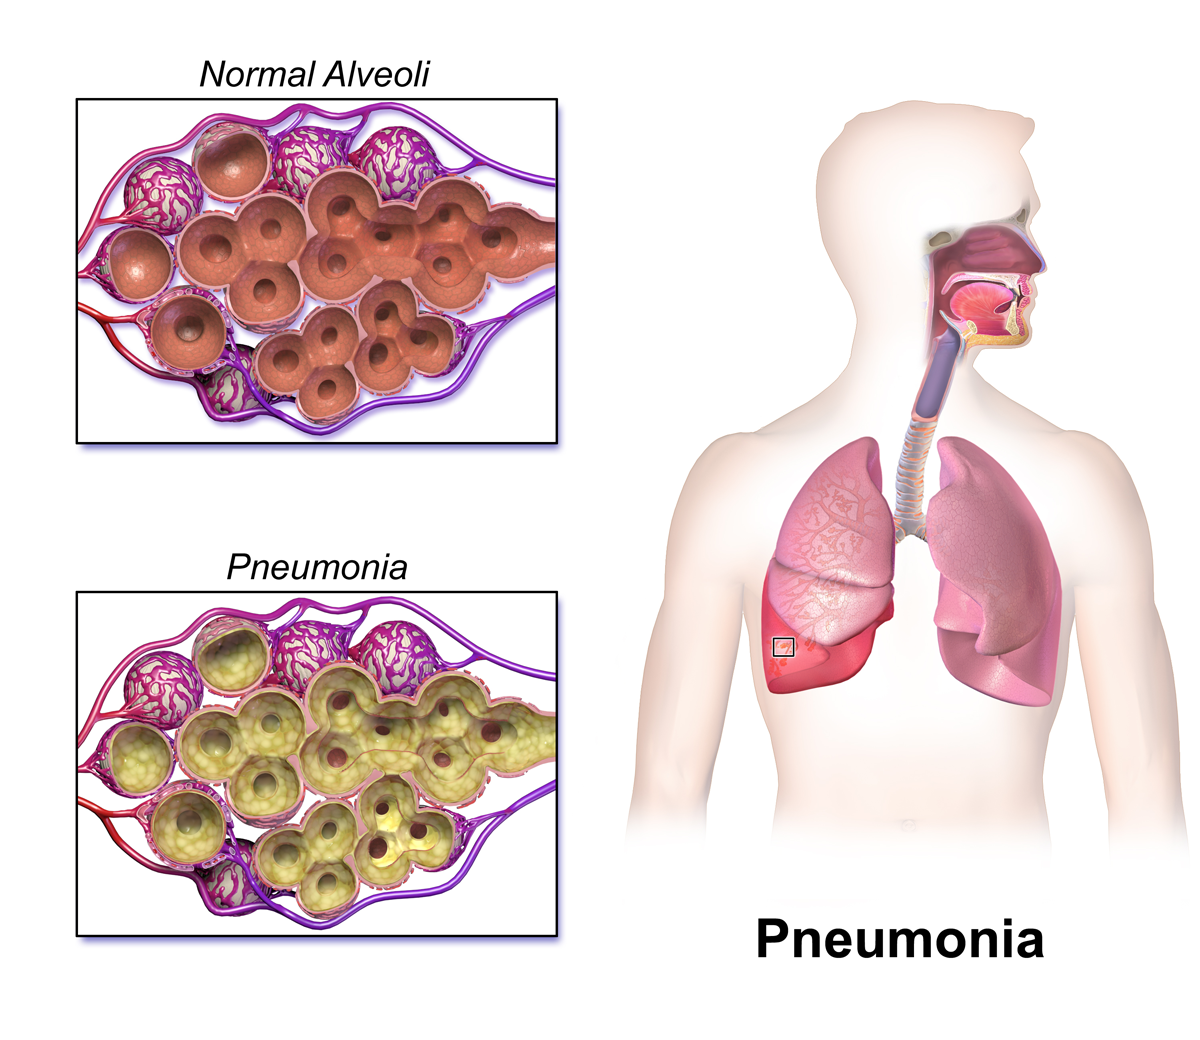

_**Figure 1. Lung sacs or alveoli in healthy patient vs lung sacs in pneumonia** Picture taken from *Wikipedia Commons* and licensed under CC BY-SA 4.0._

Rapid and accurate diagnosis is important for timely and effective treatment, and chest X-rays  are often used to help differentiate between different types of pneumonia (_**Figure 2**_), or for doing a follow  up for risk-group patients with persistent symptoms. However, quick interpretation of radiologic images is not always possible in low-resource settings of developing countries where the prevalence of childhood pneumonia is much higher. Transfer learning is a way to overcome a lack of data in a particular domain.It uses data from a related domain to improve the accuracy of a model, and has been found to be highly effective and allows the model to quickly recognize specific categories of images with fewer training examples and less computational power (Yosinski et al., 2014).


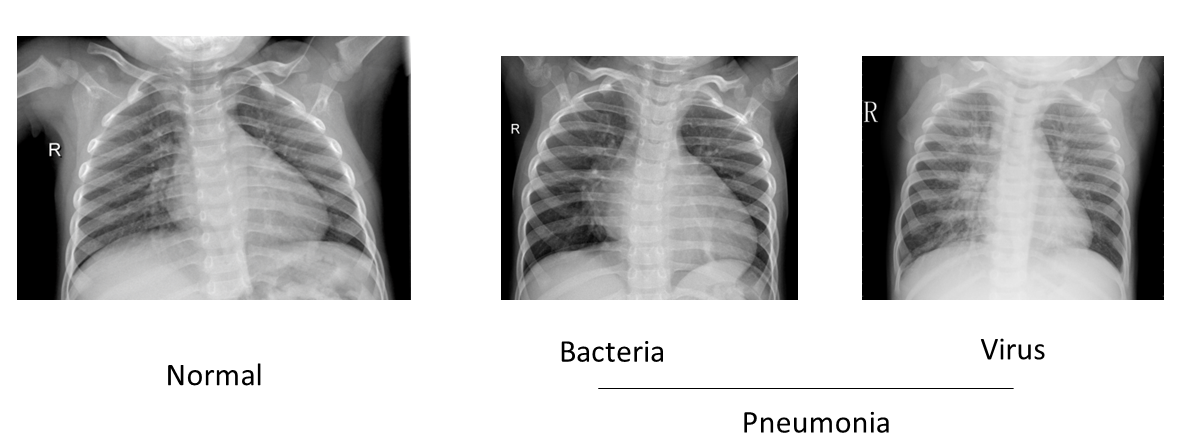


_**Figure 2. Patterns of infection in X-Ray chest images.**  A healthy lung shows no signs of purulent material  or cellular debris in alveoli (circular sacs). Bacteria tend to aggressively attack one lobe or section of the lungs causing a specific area of inflammation to take over the cells that were filled with air, and only one white condensed area with opacity will be visualized in a lung. Viruses affect both sides of the lungs with increased cellular debris and mucus and demonstrate a more “diffuse” development (Hoare *et. al*, 2006). Images taken from the Kermany *et. al* dataset and licensed under CC BY 4.0 (Kermany *et. al*, 2018)_


In this line of reasoning, the present work aims to generate a supervised machine learning model that successfully classifies pediatric chest X-rays to detect pneumonia, and can be used in a scalable learning frameworks. To this end, three different approaches were followed, training different models with the i) TensorFlow Keras library, ii) MLlib library from Pyspark and iii) DLlib library from BigDL.

<a id=#MATERIALS_AND_METHODS></a>

#**MATERIALS AND METHODS**

---
#1 Dependencies and tools

This code was developed in Google Colab, and as such, it requires a google account to run the code and to mount the file directory of current use.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A Java Developement Kit JDK of Java 8 or later versions needs to be installed and set up in order to use Apache Spark.

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import zipfile
import os

# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_352"
OpenJDK Runtime Environment (build 1.8.0_352-8u352-ga-1~20.04-b08)
OpenJDK 64-Bit Server VM (build 25.352-b08, mixed mode)


All the necessary packages for training the model with keras layers were imported in a first instance. Note that in this first stage of the work, PySpark is not going to be used to train the neural network that is going to be used to classify the X-ray images. 

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#import tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

---

#2. Dataset import

This dataset is present in Kaggle, the source we will retrieve it with the following code.

(You need to download a `kaggle.json` file containing an authentification token to download the files programmatically accessing the Kaggle Public API. Instructions of how to do this are available at the [Kaggle website](https://www.kaggle.com/docs/api))

In [ ]:
#path to the kaggle.json directory
path_API_autentification_token= '/content/drive/MyDrive/BigData Pneumonia Project'

In [ ]:
# Downloading the data to the Google Colab

import zipfile
import os

# Coping the kaggle API to the Google Colab
os.environ['KAGGLE_CONFIG_DIR'] = path_API_autentification_token

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

 99% 2.28G/2.29G [00:09<00:00, 257MB/s]
100% 2.29G/2.29G [00:09<00:00, 249MB/s]


---

#3. Data Preprocessing
## Dataset Description



The project dataset is a Pediatric chest X-ray image dataset from a paper writen by Kermany *et.al* (Kermany *et.al*, 2018). There are several characteristics in it:

- For the retrieval of the images, a cohort of pediatric patients aged 1 to 5 years old was chosen from Guangzhou Women and Children's Medical Center in Guangzhou. All Anterior-posterior X-rays were taken as part of regular medical treatment and only those that met quality control standards were selected.

- For the analsysis and labelling of the images, the images were inspected and diagnosed by two expert physicians and approved by a third expert to ensure accuracy.  The diagnoses made were used to determine the referral decisions, including "urgent referral" for bacterial pneumonia, "supportive care" for viral pneumonia, and "observation only" for normal.


A total of 5,232 chest X-ray images, including 3,883 images of pneumonia (2,538 bacterial and 1,345 viral) and 1,349 normal images, were collected and labeled from 5,856 patients to train the AI system.Thus, the image dataset is composed of three folders `train`, `test` and `val`, each of them having two folders relating to 5,863 `.jpeg` images from normal patients (present in the nested `NORMAL` folders) and patients undergoing pneumonia (present in the nested `PNEUMONIA` folders)

## Data splitting 

The data was already splitted in training, testing and validation subsets when it was acquired from the kaggle API. Thus, no further train_test splitting is needed and we can procede importing the datasets.

The following code will perform the fetching of filepaths within the `tmp` directory where the data was downloaded on.

In [ ]:
# Defining the paths of the directories that were unzipped
train_dir = '/tmp/chest_xray/train'
val_dir = '/tmp/chest_xray/val'
test_dir = '/tmp/chest_xray/test'

Importing the images into dataframes will be managed by the `image_dataset_from_directory` function from the Keras preprocessing module. First, the parameters of height and width are going to be defined for resizing the images as we will expect the them to have different dimensions. In addition, the batch size -which is the number of samples that will be propagated trough the network- is going to be defined.

In [ ]:
#Define image sizes
img_height = 128
img_width = 128
batch_size = 32

In [ ]:
#import images into dataframes
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    color_mode = 'grayscale',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    color_mode = 'grayscale',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    color_mode = 'grayscale',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


As it was expected, only two different classes are identified in the datasets, one for the controls (normal) and other for the pneumonia diagnoses. 

---

#3. Exploratory Data Analysis

## Data inspection


The following code will explore how many instances each dataset has to give us an idea of label balance for following stages of the pipeline.

In [ ]:
train_labels = []
test_labels = []
val_labels = []

for images, labels in train_df.unbatch():
  train_labels.append(labels.numpy())

for images, labels in test_df.unbatch():
  test_labels.append(labels.numpy())

for images, labels in val_df.unbatch():
  val_labels.append(labels.numpy())



In [ ]:
print("Count values of instances per label in train dataset\n")
print(pd.DataFrame(np.unique(train_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))
print("\n\nCount values of instances per label in test dataset\n")
print(pd.DataFrame(np.unique(test_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))
print("\n\nCount values of instances per label in validation dataset\n")
print(pd.DataFrame(np.unique(val_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))

Count values of instances per label in train dataset

       Normal  Pneumonia
Label       0          1
count    1341       3875


Count values of instances per label in test dataset

       Normal  Pneumonia
Label       0          1
count     234        390


Count values of instances per label in validation dataset

       Normal  Pneumonia
Label       0          1
count       8          8


There seems to be a somewhat imbalanced distribution of images that represent normal patients and images that represent pneumonia since the train and test datasets do contain more pneumonia images than control ones. This imbalance can cause problems when training the models, especially when using the accuracy or the area under the curve (AUC) metrics for their validation.

In addition, note that the train dataset is much bigger than the other two: 

- **Train dataset**: 5216 instances (89.0%)
- **Test dataset**: 624 instances (10.7%)
- **Validation dataset**: 16 instances (0.3%)
- **Total**: 5856 instances

## Images visualiztion

Visualization of part of the training dataset. Now that our images have been preprocessed, we will find them to have the same dimensions (width and height). All images will have $128 \times 128$ dimensions.

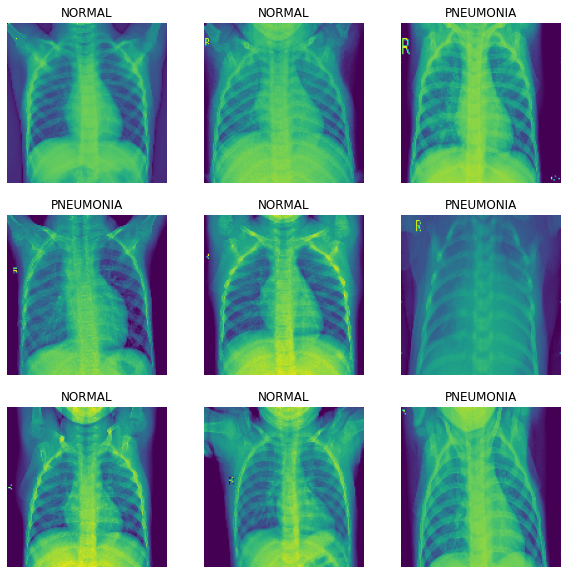

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        plt.title(train_df.class_names[labels[i]])
        plt.axis("off")

`tf.data` builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

---

# 4. Keras NN model implementation 

Next, we will define the model:

- We will use the **keras layers experimental preprocessing module** as a first stage of the model to rescale image input values to a new normalized range from 0 (zero light in any RGB channel value) to 1 (maximum light in any RGB channel value).
- The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function, concatenated by another `Dense` layer with Softmax activation to normalize the output of the network to a probability distribution over the 2 potential classes.

In [ ]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

We will use an **adam** optimizer (since it has faster computation time - required for our big training sample-, and requires fewer parameters for tuning)  and a sparse categorical crossentropy loss function, which produces a category index of the most likely matching integer label, and is recommended when de dataset is too large. We will use accuracy as an intuitive evaluation metric of the preliminary model, although it might not be the most correcct approach as the labels were imbalanced in the training dataset.

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Model training

Fitting the model with our training dataset is the next step. To this end, the `model.fit()` was used. In addition, the model was evaluated in each training epoch using the validation dataset provided by kaggle. This might no be optimal, as the validation dataset is really small in comparison with the training dataset as it contains only a 0.3% of the total instances. A 80-10-10 (train-validation-test) partition would have been more ideal. 

In [ ]:
epochs = 10
history= model.fit(
                train_df,
                validation_data=val_df,
                epochs=epochs
            )

Epoch 1/10
163/163 [==============================] - 125s 743ms/step - loss: 0.2354 - accuracy: 0.8993 - val_loss: 0.6636 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 86s 526ms/step - loss: 0.1011 - accuracy: 0.9620 - val_loss: 0.8630 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 88s 538ms/step - loss: 0.0868 - accuracy: 0.9689 - val_loss: 0.6963 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 86s 525ms/step - loss: 0.0752 - accuracy: 0.9747 - val_loss: 0.3595 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 90s 553ms/step - loss: 0.0558 - accuracy: 0.9801 - val_loss: 0.1944 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 88s 539ms/step - loss: 0.0471 - accuracy: 0.9826 - val_loss: 0.2569 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 85s 521ms/step - loss: 0.0362 - accuracy: 0.9877 - val_loss: 0.2160 - val_a

After 10 training epochs, a training accuracy of 99.33% and a validation accuracy of 93.75% is achieved, indicating that most of the validation instances are correctly predicted with this model. 

## Model evaluation

The model is going to be evaluated with the test dataset that contained a 10% of the total instances. Therefore, the evaluation is going to be more representative and it is going to help detecting a possible overfitting. 

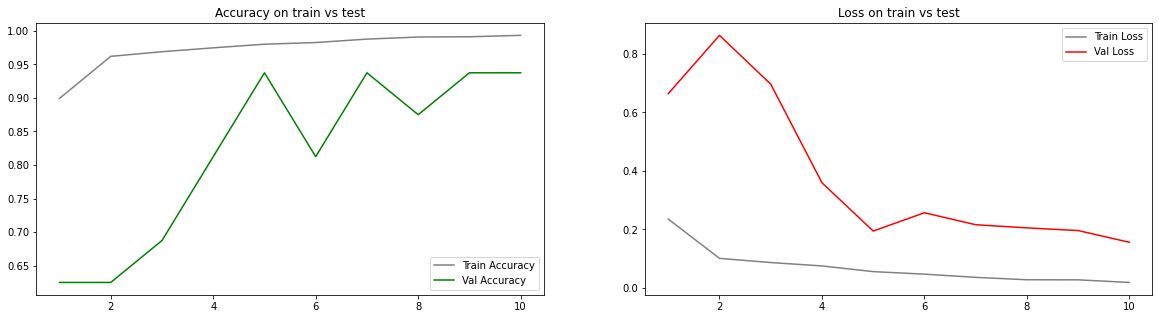

In [ ]:
plt.figure(figsize=(20,5))

# ploting accuracy and validation accuracy
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='grey', label='Train Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

# plotting loss and validation loss (sparse categorical crossentropy)
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='grey', label='Train Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='red', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.show()

In [ ]:
model.evaluate(test_df)

20/20 [==============================] - 5s 185ms/step - loss: 1.4483 - accuracy: 0.8061


[1.448348045349121, 0.8060897588729858]

We deem this accuracy -80.6%- to be good enough, and crossvalidation throughout the training epochs show acceptable levels of accuracy and loss. Even if there are more pneumonia images in the training dataset, our final evaluation had a high accuracy. 

In future work, we could try to improve the model by increasing the number of epochs and the number of validation instances. 

---
# 5. Model training using PySpark MLlib

In this stage of the present work the `MLlib` library of PySpark is going to be used to build a more scalable model. In this way, we are going to build a Logistic Regression and a Random Forest model using cross validation to find out the best hyperparameters. 

### Import the PySpark session

In [ ]:
appname = "Predicting pneumonia"

# Look into https://spark.apache.org/downloads.html for the latest version
spark_mirror = "https://mirrors.sonic.net/apache/spark"
spark_version = "3.3.1"
hadoop_version = "3"

# Install Java 8 (Spark does not work with newer Java versions)
! apt-get update
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Spark binary distribution
! rm -rf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz spark-{spark_version}-bin-hadoop{hadoop_version}
! wget -q {spark_mirror}/spark-{spark_version}/spark-{spark_version}-bin-hadoop{hadoop_version}.tgz
! tar xzf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz

# The only 2 environment variables needed to set up Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{spark_version}-bin-hadoop{hadoop_version}"

# Set up the Spark environment based on the environment variable SPARK_HOME 
! pip install -q findspark
import findspark
findspark.init()

# Get the Spark session object (basic entry point for every operation)
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [71.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:14 http://security.ubuntu.com/

## Importing necessary functions

In [ ]:
from pyspark.sql.functions import lit
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.ml.image import ImageSchema
from pyspark.sql.types import ArrayType, IntegerType, StringType
from pyspark.sql.functions import rand # shuffling
import cv2 # image preprocessing
import numpy as np

## Data import

Note that we are going to import again the datasets as in the last stage we had imported them directly using the `keras.preprocessing` method and now we want them as spark dataframes.

The first step is defining lists with image file paths.

In [ ]:
import glob2
# Picking only the jpeg files 
train_normal_cases = glob2.glob(train_dir + '/NORMAL/' + '*jpeg')
train_pneumonia_cases = glob2.glob(train_dir + '/PNEUMONIA/' + '*jpeg')

test_normal_cases = glob2.glob(test_dir + '/NORMAL/' + '*jpeg')
test_pneumonia_cases = glob2.glob(test_dir + '/PNEUMONIA/'+ '*jpeg')

val_normal_cases = glob2.glob(val_dir + '/NORMAL/' + '*jpeg')
val_pneumonia_cases = glob2.glob(val_dir + '/PNEUMONIA/' + '*jpeg')

# giving column names of dataframe
columns = ["path", "label"]

Then, spark dataframes are created. Each X-ray image is going to be a different instance. 

### Train spark dataframe creation and repartition:

In [ ]:
# list train data
data_tr_normal = [[path_train_normal, 0.0] for path_train_normal in train_normal_cases]
data_tr_pneumonia = [[path_train_pneumonia, 1.0] for path_train_pneumonia in train_pneumonia_cases] 
  
# creating a dataframe
train_normal_df = spark.createDataFrame(data_tr_normal, columns)
train_pneumonia_df = spark.createDataFrame(data_tr_pneumonia, columns)

# Dataframe for training a classification model
train_df = train_normal_df.unionAll(train_pneumonia_df)

# Ensure that each of the partitions has a small size. 
train_df = train_df.repartition(100)

### Test dataset spark dataframe creation and repartition:

In [ ]:
# list test data
data_te_normal = [[path_test_normal, 0.0] for path_test_normal in test_normal_cases]
data_te_pneumonia = [[path_test_pneumonia, 1.0] for path_test_pneumonia in test_pneumonia_cases] 
  
# creating a dataframe
test_normal_df = spark.createDataFrame(data_te_normal, columns)
test_pneumonia_df = spark.createDataFrame(data_te_pneumonia, columns)

# Dataframe for testing the classification model
test_df = test_normal_df.unionAll(test_pneumonia_df)

# Ensure that each of the partitions has a small size. 
test_df = test_df.repartition(100)

### Validation dataset spark dataframe creation and repartition:

In [ ]:
# list val data
data_v_normal = [[path_val_normal, 0.0] for path_val_normal in val_normal_cases]
data_v_pneumonia = [[path_val_pneumonia, 1.0] for path_val_pneumonia in val_pneumonia_cases] 
  
# creating a dataframe
val_normal_df = spark.createDataFrame(data_v_normal, columns)
val_pneumonia_df = spark.createDataFrame(data_v_pneumonia, columns)

# Dataframe for validating the classification model
val_df = val_normal_df.unionAll(val_pneumonia_df)

# Ensure that each of the partitions has a small size. 
val_df = val_df.repartition(100)

Lastly, the instances are going to be shuffled to ensure that they are ordered at random. 

In [ ]:
# Shuffle dataframes for more randomness
train_df = train_df.orderBy(rand())
test_df = test_df.orderBy(rand())
val_df = val_df.orderBy(rand())

### Data inspection

All dataframes are going to be composed of the paths of each image and its corresponding label: normal (0.0) and pneumonia (1.0). In this section we are only going to print the validation dataset as it is the smallest one. 

In [ ]:
#print dataframe
val_df.show()

+--------------------+-----+
|                path|label|
+--------------------+-----+
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  1.0|
|/tmp/chest_xray/v...|  0.0|
|/tmp/chest_xray/v...|  1.0|
+--------------------+-----+



In [ ]:
val_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
#Data visualization
train_df.groupBy('label').count().show()
test_df.groupBy('label').count().show()
val_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1341|
|  1.0| 3875|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  234|
|  1.0|  390|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  0.0|    8|
|  1.0|    8|
+-----+-----+



### Data preprocessing 

Creating a User Defined Function (UDF) in Spark to convert the image to a pixel vector of a single channel and size $64 \times 64$. In addition, the data is going to be scaled by dividing each pixel by 255.

In [ ]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

@F.udf(VectorUDT())
def image_to_vector_udf(imagepath: StringType):
  img = cv2.imread(imagepath) #read the image
  img = cv2.resize(img, (32, 32)) #resize
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #change color scale to gray
  img = img/255.0
  img = np.reshape(img, (32,32,1)).flatten().tolist()
  #flat_list = [item for sublist in img for item in sublist]
  return Vectors.dense(img)


# Aplicar la UDF a la columna de imagen
train_df = train_df.withColumn("features", image_to_vector_udf(train_df["path"]))
test_df = test_df.withColumn("features", image_to_vector_udf(test_df["path"]))
val_df = val_df.withColumn("features", image_to_vector_udf(val_df["path"]))


list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

train_df = train_df.select(
    train_df["label"], 
    list_to_vector_udf(train_df["features"]).alias("features")
)

test_df = test_df.select(
    test_df["label"], 
    list_to_vector_udf(test_df["features"]).alias("features")
)

val_df = val_df.select(
    val_df["label"], 
    list_to_vector_udf(val_df["features"]).alias("features")
)

In [ ]:
#print dataframe
val_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.05490196078431...|
|  1.0|[0.01960784313725...|
|  1.0|[0.00392156862745...|
|  1.0|[0.0,0.0039215686...|
|  0.0|[0.40392156862745...|
|  0.0|[0.29019607843137...|
|  0.0|[0.22745098039215...|
|  0.0|[0.39607843137254...|
|  0.0|[0.07450980392156...|
|  0.0|[0.14901960784313...|
|  1.0|[0.01960784313725...|
|  1.0|[0.20392156862745...|
|  1.0|[0.09411764705882...|
|  1.0|[0.09411764705882...|
|  0.0|[0.03137254901960...|
|  1.0|[0.0,0.0313725490...|
+-----+--------------------+



In [ ]:
#print schema
val_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



### Model Training

Each of the colleagues in our group focused in training the preprocessed data with different implementations of the Logistic Regression and Random Forest `pyspark.ml.classification` models using cross validation in order to find the best possible model for our data. 

As we are working with a big training dataset that contains more than 5 thousand images, only 4 folds are going to be defined for the cross validation. The cross validation method is going to dived the training dataset into two segemnts: one used to train the model and the other to validate it. This process is going to be performed 4 times, one for each fold. This approach is better to ensure the best model and hyperparameters than using directly the validation dataset as it only contained 16 instances. 

To this end, `ParamGridBuilder` and `CrossValidator` are going to be used to tune the model. 

The hyperparameter tuning and best model selection is going to be based on the **F1-score** metric as it performs better than AUC or accuracy on imbalanced datasets. Thus, the MLlib `MulticlassClassificationEvaluator` is going to be used as the cross validation evaluator since its default metric is the F1-score.

The F1-score is a straight forward calculation involved the overall recall and precision of the model and it can be defined as 

$$
  F1 = 2 · \frac{Precision \times Recall}{Precision + Recall}
$$

Therefore, this metric score rangres from 0 to 1, where 0 indicates that it is a bad model and 1 is the best possible score. 

### *Logistic Regression*

First, we are going to select the best logistic regression model and train it model using the training dataset. The 4-fold cross validator is going to choose between 3 possible values for `maxIter` (number of iterations), 3 values for `regParam` (regularization parameter) and 3 `threshold` values. The regularization paramter in logistic regression is needed to try to prevent the algorithm from overfitting the training dataset.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

estimator = LogisticRegression(labelCol='label')


evaluator = MulticlassClassificationEvaluator(labelCol='label')

logr = estimator
params = ParamGridBuilder() \
    .addGrid(logr.maxIter,   [ 100, 200, 300 ]) \
    .addGrid(logr.regParam,  [ 0.0, 0.01, 0.1 ]) \
    .addGrid(logr.threshold, [ 0.1, 0.5, 0.8 ]) \
    .build()

crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=params,
                          evaluator=evaluator,
                          numFolds=4)

model = crossval.fit(train_df)

### Best model parameters and train evaluation metrics



In [ ]:
cvModel = model.bestModel

In [ ]:
print("Best model parameters: \n----")

print('Best Param (regParam): ', cvModel._java_obj.getRegParam())

print('Best Param (MaxIter): ', cvModel._java_obj.getMaxIter())

print('Best Param (threshold): ', cvModel._java_obj.getThreshold())

Best model parameters: 
----
Best Param (regParam):  0.01
Best Param (MaxIter):  100
Best Param (threshold):  0.5


In [ ]:
print("\nBest Model accuracy : " , cvModel.summary.accuracy)
print("-------------\nBest Model recall by label [0 - normal ,1 - pneumonia] \n\n " , cvModel.summary.recallByLabel)
print("-------------\nBest Model precision by label [0 - normal ,1 - pneumonia] \n\n " , cvModel.summary.precisionByLabel)
print("-------------\nBest Model False positive rate by label [0 - normal ,1 - pneumonia] \n\n " , cvModel.summary.falsePositiveRateByLabel)


Best Model accuracy :  0.9831288343558282
-------------
Best Model recall by label [0 - normal ,1 - pneumonia] 

  [0.9604772557792692, 0.9909677419354839]
-------------
Best Model precision by label [0 - normal ,1 - pneumonia] 

  [0.9735449735449735, 0.9863858207038274]
-------------
Best Model False positive rate by label [0 - normal ,1 - pneumonia] 

  [0.00903225806451613, 0.0395227442207308]


### Test evaluation metrics

Now we will test the best model with the `test_df` dataset. First we will print the F1-score for our best Logistic Regression model from the predictions for the test dataset.

In [ ]:
results = model.transform(test_df)
Met = evaluator.evaluate(results)
print("Test F1 score:", Met)

Test F1 score: 0.7116433771232533


The F1-score can take values ranging from 0 to 1 and the higher the value, the better the model. Thus, we can conclude that the model is good enough to classify X-ray images to help pneumonia diagnosis.

In [ ]:
#print the prediction
results.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[0.49803921568627...|[1.37781345473469...|[0.79863960190967...|       0.0|
|  0.0|[0.12549019607843...|[-0.9039749276680...|[0.28823433395255...|       1.0|
|  0.0|[0.06666666666666...|[-4.8359840531838...|[0.00787634292742...|       1.0|
|  1.0|[0.35686274509803...|[-7.6237305166110...|[4.88476539856022...|       1.0|
|  0.0|[0.0,0.0941176470...|[1.51081520389863...|[0.81918198859983...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



However, we can also compute other evaluation metrics such as the precision or the recall for both labels. This will give us more insight on the performance of our model and wether it is good enough to help pneumonia diagnosis from X-ray images. 

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark import SparkContext
sc=spark.sparkContext

# Compute raw scores on the test set
predictionAndLabels = sc.parallelize(results.select('label','prediction').toPandas().values.tolist())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

/content/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Statistics by class
labels = [0.0, 1.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print()
print()

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Class 0.0 precision = 0.3547008547008547
Class 0.0 recall = 0.9325842696629213
Class 0.0 F1 Measure = 0.5139318885448917

Class 1.0 precision = 0.9846153846153847
Class 1.0 recall = 0.7177570093457943
Class 1.0 F1 Measure = 0.8302702702702702


Weighted recall = 0.7483974358974358
Weighted precision = 0.8947718058294982
Weighted F(1) Score = 0.7851514946716185
Weighted F(0.5) Score = 0.8435006552424622
Weighted false positive rate = 0.09805615688872016


In [ ]:
print("FP Metrics per label (normal, pneumonia): (" , metrics.falsePositiveRate(0.0), ",",  metrics.falsePositiveRate(1.0), ")")

FP Metrics per label (normal, pneumonia): ( 0.2822429906542056 , 0.06741573033707865 )


The metrics are wors than the ones obtained for the training dataset -as it usually happens-. This suggest that there is some overfitting. 

In addition, the results show that we can be more confident for the patients that are dianoses from pneuomonia than those who are not since the precision for label 1 is much higher than the one for label 0. Thus, a patient not being diagnosed with pneumonia does not necessarily mean that they are not healthy. 

The weighted metrics are not bad, with the recall being 0.75, the precision 0.89 and the F1-score being 0.79. The weighted precision is high even if the precision for label 0 is quite bad because there were much more instances classified as "ill" in the test dataset, which was imbalanced.

### Confusion matrix

In [ ]:
conf_m=metrics.confusionMatrix().toArray()

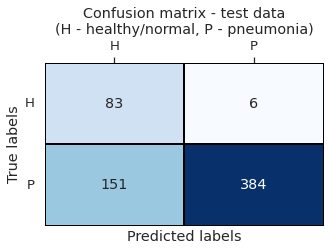

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the confussion matrix as a heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

### *Random Forest*

In this case, the 4-fold cross validator is going to choose between 3 possible values for `numTrees` (number of trees) and 3 values for `maxDepth` (maximum depth). The larger the number of trees, usually the better, but it might have a high computational cost. 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

estimator = RandomForestClassifier(labelCol='label')


evaluator = MulticlassClassificationEvaluator(labelCol='label')

rfc = estimator
params = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [ 20, 50, 100 ]) \
    .addGrid(rfc.maxDepth, [ 3, 5, 7 ]) \
    .build()

crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=params,
                          evaluator=evaluator,
                          numFolds=4)

model_rf = crossval.fit(train_df)

### Best model parameters and train evaluation metrics

In [ ]:
cvModel_rf = model_rf.bestModel

In [ ]:
print("Random Forest best model parameters: \n----")

print('Best Param (numTrees): ', cvModel_rf._java_obj.getNumTrees())

print('Best Param (maxDepth): ', cvModel_rf._java_obj.getMaxDepth())

Random Forest best model parameters: 
----
Best Param (numTrees):  100
Best Param (maxDepth):  7


In [ ]:
print("\nBest Model accuracy : " , cvModel_rf.summary.accuracy)
print("-------------\nBest Model recall by label [0 - normal ,1 - pneumonia] \n\n " , cvModel_rf.summary.recallByLabel)
print("-------------\nBest Model precision by label [0 - normal ,1 - pneumonia] \n\n " , cvModel_rf.summary.precisionByLabel)
print("-------------\nBest Model False positive rate by label [0 - normal ,1 - pneumonia] \n\n " , cvModel_rf.summary.falsePositiveRateByLabel)


Best Model accuracy :  0.9810199386503068
-------------
Best Model recall by label [0 - normal ,1 - pneumonia] 

  [0.947800149142431, 0.992516129032258]
-------------
Best Model precision by label [0 - normal ,1 - pneumonia] 

  [0.9776923076923076, 0.9821246169560777]
-------------
Best Model False positive rate by label [0 - normal ,1 - pneumonia] 

  [0.007483870967741935, 0.05219985085756898]


## Test evaluation metrics

In [ ]:
results_rf = model_rf.transform(test_df)

Now we will print the F1-score for our best Random Forest model

In [ ]:
Met_rf = evaluator.evaluate(results_rf)
print("Test F1 score:", Met_rf)

Test F1 score: 0.759173203614516


In [ ]:
results_rf.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[0.15294117647058...|[22.8720355225396...|[0.22872035522539...|       1.0|
|  0.0|[0.0,0.0,0.298039...|[52.1245927583610...|[0.52124592758361...|       0.0|
|  1.0|[0.47058823529411...|[1.55189293338247...|[0.01551892933382...|       1.0|
|  1.0|[0.05490196078431...|[7.32468890183518...|[0.07324688901835...|       1.0|
|  1.0|[0.14117647058823...|[11.8699182725193...|[0.11869918272519...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



However, we can also compute other evaluation metrics such as the precision or the recall for both labels. This will give us more insight on the performance of our model and wether it is good enough to help pneumonia diagnosis from X-ray images. 

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark import SparkContext
sc=spark.sparkContext

# Compute raw scores on the test set
predictionAndLabels_rf = sc.parallelize(results_rf.select('label','prediction').toPandas().values.tolist())

# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)

/content/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Statistics by class
labels = [0.0, 1.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics_rf.precision(label)))
    print("Class %s recall = %s" % (label, metrics_rf.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics_rf.fMeasure(label, beta=1.0)))
    print()
print()

# Weighted stats
print("Weighted recall = %s" % metrics_rf.weightedRecall)
print("Weighted precision = %s" % metrics_rf.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics_rf.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics_rf.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics_rf.weightedFalsePositiveRate)

Class 0.0 precision = 0.4444444444444444
Class 0.0 recall = 0.9541284403669725
Class 0.0 F1 Measure = 0.6064139941690962

Class 1.0 precision = 0.9871794871794872
Class 1.0 recall = 0.7475728155339806
Class 1.0 F1 Measure = 0.8508287292817679


Weighted recall = 0.7836538461538461
Weighted precision = 0.8923748082401929
Weighted F(1) Score = 0.8081344886931763
Weighted F(0.5) Score = 0.8525806390819074
Weighted false positive rate = 0.0819525902528931


In [ ]:
print("FP Metrics per label (normal, pneumonia): (" , metrics_rf.falsePositiveRate(0.0), ",",  metrics_rf.falsePositiveRate(1.0), ")")

FP Metrics per label (normal, pneumonia): ( 0.2524271844660194 , 0.045871559633027525 )


The metrics are wors than the ones obtained for the training dataset -as it usually happens-. This suggest that there is some overfitting. 

In addition, the results show that we can be more confident for the patients that are dianoses from pneuomonia than those who are not since the precision for label 1 is much higher than the one for label 0. Thus, a patient not being diagnosed with pneumonia does not necessarily mean that they are not healthy. The healthy false positive rate being high, close to 25%, also supports this conclusion.

The weighted metrics are not bad, with the recall being 0.78, the precision 0.89 and the F1-score being 0.81. The weighted precision is high even if the precision for label 0 is quite bad because there were much more instances classified as "ill" in the test dataset, which was imbalanced.

### Confusion matrix

In [ ]:
conf_m_rf=metrics_rf.confusionMatrix().toArray()

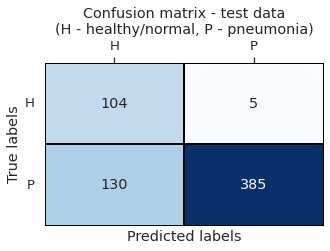

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the confussion matrix as a heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m_rf, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

### *Model comparison*

The results show that the Random Forest model performs better than the Logistic Regression one in terms of F1-score. It is important to note that our pyspark API did not take the validation set specified by kaggle but performed a default 0.75/0.25 split in our training dataset. We consider, however, that as there are only 16 instances in the original validation set, the loss of information will be negligible, and the final validation dataset will be more representative of the dataset and more precise for our task of determining the best model.

It is also worth to mention that our class labels are very imbalanced being a substantial amount of instances in our training datasets from pneumonia patients (label 1.0). This value is around 70-75% in both trained models, which is not bad, although it could be better. The label imbalance is why a F1 metric should be used to perform crossvalidation and check the best model of the two. 

This results in a much higher value for False positives in Normal patient predictions -around 25% in the random forest model-, and by extension, a much higher value for Pneumonia False negatives. This effect can also be appreciated in the precision/recall per label values, and consequently, lower F1 score values. In this sense, the Random Forest is the best model, whith a higher F1-score value and lower false positive rate.

Also, we should choose the model that has higher recall from the two (better to predict false positive pneumonia than to retrieve false negatives and let more patients not be treated urgently and die). Both models have similar recall values, being slightly better in the random forest model where the recall is 0.78.

Taking all the arguments into account, we can conclude that the Random Forest model performs slightly better than the Logistic Regresion model for our data. Nevertheless, both of them should be further improved, maybe by introducing more folds in the cross validation or trying more hyperparameters as both models predict some pneumonia patients to be healthy when they are ill. Despite this is still more desirable than treating a patient when they are not ill, since drugs can have secondary effects or potentiate antibiotic resisance, these models should be complemented with other techniques or an expert criterium to further confirm the results to avoid having sick patients who do not receive treatment because they are predicted to be healthy. 

In addition, from the results we can be more confident of the patients that are predicted as having pneuomonia as almost all the patients predicted as being ill from their X-ray images do have pneuomnia. These patients could be treated immediately, On the other hand, if the results for a patient are negative, further medical tests should be carried out to ensure that he is really healthy.  


---

#6. Model training with BigDL

We will need to work with the latest version of BigDL and Dllib for this. The following cell will also install pyspark

In [ ]:
# Install latest pre-release version of bigdl-dllib with spark3
# Find the latest bigdl-dllib with spark3 from https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/ and intall it
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 MB 6.1 MB/s eta 0:00:00


In [ ]:
# import necesary libraries and modules
#from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
from bigdl.dllib.nn.criterion import *
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

Prepending /usr/local/lib/python3.8/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path


In [ ]:
from pyspark.sql import SparkSession

sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.8/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.8/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


### Import data

In [ ]:
#Import data

import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType,StringType
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import lit

# giving column names of dataframe

columns = ["path", "label"]


# list train data
data_tr_normal = [[path_train_normal, 0.0] for path_train_normal in train_normal_cases]
data_tr_pneumonia = [[path_train_pneumonia, 1.0] for path_train_pneumonia in train_pneumonia_cases] 


# creating a dataframe
train_normal_df = spark.createDataFrame(data_tr_normal, columns)
train_pneumonia_df = spark.createDataFrame(data_tr_pneumonia, columns)


# Dataframe for training a classification model
train_df = train_normal_df.unionAll(train_pneumonia_df)

# Ensure that each of the partitions has a small size. 
train_df = train_df.repartition(100)


#-

# list test data
data_te_normal = [[path_test_normal, 0.0] for path_test_normal in test_normal_cases]
data_te_pneumonia = [[path_test_pneumonia, 1.0] for path_test_pneumonia in test_pneumonia_cases] 


# creating a dataframe

test_normal_df = spark.createDataFrame(data_te_normal, columns)
test_pneumonia_df = spark.createDataFrame(data_te_pneumonia, columns)


# Dataframe for testing the classification model
test_df = test_normal_df.unionAll(test_pneumonia_df)

# Ensure that each of the partitions has a small size. 
test_df = test_df.repartition(100)



#--


# list val data
data_v_normal = [[path_val_normal, 0.0] for path_val_normal in val_normal_cases]
data_v_pneumonia = [[path_val_pneumonia, 1.0] for path_val_pneumonia in val_pneumonia_cases] 


# creating a dataframe
val_normal_df = spark.createDataFrame(data_v_normal, columns)
val_pneumonia_df = spark.createDataFrame(data_v_pneumonia, columns)

# Dataframe for validating the classification model
val_df = val_normal_df.unionAll(val_pneumonia_df)

# Ensure that each of the partitions has a small size. 
val_df = val_df.repartition(100)

from pyspark.sql.functions import rand 


# Shuffle dataframes for more randomness

train_df = train_df.orderBy(rand())
test_df = test_df.orderBy(rand())
val_df = val_df.orderBy(rand())


@F.udf(VectorUDT())
def image_to_vector_udf(imagepath: StringType):
  """Pass image paths and convert it to a scaled 64*64 array with one Black and White to 1 channel"""
  img = cv2.imread(imagepath)
  img = cv2.resize(img, (64, 64))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = img/255.0
  img = np.reshape(img, (64,64,1)).flatten().tolist()
  return Vectors.dense(img)


# Aplicar la UDF a la columna de imagen
train_df = train_df.withColumn("features", image_to_vector_udf(train_df["path"]))
test_df = test_df.withColumn("features", image_to_vector_udf(test_df["path"]))
val_df = val_df.withColumn("features", image_to_vector_udf(val_df["path"]))

### Create model

In [ ]:
num_fc = 512
num_outputs = 2

model = Sequential()
model.add(Reshape((1, 28, 28), input_shape=(64, 64, 1)))
model.add(Convolution2D(20, 3, 3, activation="relu", input_shape=(1, 28, 28)))
model.add(MaxPooling2D())
model.add(Convolution2D(50, 3, 3, activation="relu", name="conv2_5x5"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(num_fc, activation="relu", name="fc1"))
model.add(Dense(num_outputs, activation="softmax", name="fc2"))

print(model.get_input_shape())
print(model.get_output_shape())

creating: createZooKerasSequential
creating: createZooKerasReshape
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasDense
(None, 28, 28, 1)
(None, 2)


In [ ]:
#Configure training
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd',
                metrics=['accuracy', 
                         TruePositives(name='TP'), 
                          FalsePositives(name='FP'), 
                          TrueNegatives(name='TN'),
                          FalseNegatives(name='FN')])


creating: createDefault
creating: createSGD
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasSparseCategoricalAccuracy


### Train model

In [ ]:
#Execute training
history = model.fit(X_train, y_train, batch_size=8, nb_epoch=1,validation_data=(X_val, y_val))

Evaluating the model once again but allong the modelling phase

In [ ]:
plt.figure(figsize=(20,5))

# ploting loss y val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plotting accuracy y val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

Plotting a confusion matrix

In [ ]:
model.evaluate(test_df)

In [ ]:
# Performing our prediction over the test, and obtaining the real value stored in the labels
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

# Calculating the confussion matrix and the classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# Plotting the confussion matrix as a heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# Checking the classification report
print('Classification report on test data')
print(clas_r)

<a id=#CONCLUSION></a>

#**CONCLUSIONS**

Medical imaging has long been an important part of medical care and has evolved with recent advances in scanning procedures. These imaging techniques now enable the identification of subtle changes in physiological variables and can assist  educated health specialists abd practiotioners that find this detection tasks challenging with the use of AI. However, these AI technologies may still be improved, and a transition to more powerful AI tools is required.

Furthermore, the employment of deep learning algorithms provides a scalable approach, with improved performance projected as more data is collected and research progresses. This results in more accuracy and fewer time-consuming and challenging everyday chores.


<a id=#REFERENCES></a>

#**REFERENCES**

- **Hoare, Z., & Lim, W. S.** (2006). Pneumonia: Update on diagnosis and management. BMJ : *British Medical Journal*, 332(7549), 1077–1079.
Hunton, R. (2019). Updated concepts in the diagnosis and management of community-acquired pneumonia. JAAPA: Official Journal of the American Academy of Physician Assistants, 32(10), 18–23. https://doi.org/10.1097/01.JAA.0000580528.33851.0c

- **J. Deng, W. Dong, R. Socher, L. -J. Li, Kai Li and Li Fei-Fei** (2009), "ImageNet: A large-scale hierarchical image database,"  IEEE Conference on Computer Vision and Pattern Recognition, Miami, FL, USA, 2009, pp. 248-255, doi: 10.1109/CVPR.2009.5206848.

- **Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C. C. S., Liang, H., Baxter, S. L., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M. K., Pei, J., Ting, M. Y. L., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., … Zhang, K.** (2018). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. *Cell*, 172(5), 1122-1131.e9. https://doi.org/10.1016/j.cell.2018.02.010

- **McLuckie, A.** (2009). Respiratory Disease and its Management. *Springer Science & Business Media*.

- **Pneumonia—Diagnosis | NHLBI, NIH.** (2022, March 24). https://www.nhlbi.nih.gov/health/pneumonia/diagnosis

- **Regunath, H., & Oba, Y.** (2022). Community-Acquired Pneumonia. In StatPearls [Internet]. *StatPearls Publishing*. https://www.ncbi.nlm.nih.gov/books/NBK430749/

- **Rudan, I., Boschi-Pinto, C., Biloglav, Z., Mulholland, K., & Campbell, H.** (2008). Epidemiology and etiology of childhood pneumonia. *Bulletin of the World Health Organization*, 86(5), 408–416. https://doi.org/10.2471/blt.07.048769

- **Yosinski, J., Clune, J., Bengio, Y., & Lipson, H.** (2014). How transferable are features in deep neural networks? (arXiv:1411.1792). *arXiv.* https://doi.org/10.48550/arXiv.1411.1792

